In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from statsmodels.api import Logit

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score,roc_curve,auc
import seaborn as sns

from statsmodels.api import qqplot, add_constant

# 파일읽기

In [3]:
df = pd.read_csv(os.getcwd()+"/SCALE불량.csv",engine='python',encoding='euc-kr')
df.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


# 양품 =0, 불량 =1
# SPEC의 두글자만 받아오기

In [4]:
df['SCALE']=np.where(df['SCALE']=="양품",0,1)
df['HSB']=np.where(df['HSB']=="적용",1,0)
#spec 앞에 두글자만 가져오기
tmp=[]
for i in df['SPEC']:
    tmp.append(i[0:2])

    
cnt=0
for i in tmp:
    if i == 'A1': tmp[cnt]='other'
    elif i=='A2': tmp[cnt]='other'
    elif i=='A5': tmp[cnt]='other'
    elif i=='A7': tmp[cnt]='other'
    elif i=='AP': tmp[cnt]='other'
    elif i=='CC': tmp[cnt]='other'
    elif i=='SA': tmp[cnt]='other'
    elif i=='V4': tmp[cnt]='other'
    else : pass
    cnt+=1
    
    
df['SPEC_f'] = tmp

# 변수 제거 / 카이스퀘어로 나온 상관없는 변수 제거
df= df.drop(['PLATE_NO','ROLLING_DATE','WORK_GR','FUR_NO','SPEC','FUR_EXTEMP'],axis=1)


In [5]:
df.isnull().sum()


# 강종이 C1인게 하나이므로 삭제
df['STEEL_KIND'].value_counts()

# df_scaled = df_scaled.drop(df_scaled[df_scaled['STEEL_KIND']=='C1'].index)
# len(df_scaled)

tmp=[]
for i in df['STEEL_KIND']:
    tmp.append(i)

    
cnt=0
for i in tmp:
    if i == 'C3': tmp[cnt]='other'
    elif i=='T3': tmp[cnt]='other'
    elif i=='C1': tmp[cnt]='other'
    else : pass
    cnt+=1
    
    
df['STEEL_KIND'] = tmp
df['STEEL_KIND'].value_counts()

C0       503
T8        95
T5        43
T7        35
T1        18
T0        16
other     10
Name: STEEL_KIND, dtype: int64

In [6]:
df['SPEC_f'].value_counts()

JS       146
NV       105
LR       105
BV        86
GL        56
PI        40
other     38
AB        37
KR        31
KS        28
CO        28
NK        20
Name: SPEC_f, dtype: int64

In [7]:
df.describe()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.320833,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.527778,1149.666667,78.802778,300.563889,933.920833,0.954167,8.319444
std,0.467121,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,37.660799,17.571788,36.421004,45.390303,107.863887,0.209269,1.623252
min,0.000000,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,0.000000,0.000000,5.000000
25%,0.000000,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,889.750000,1.000000,6.000000
50%,0.000000,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,951.000000,1.000000,8.000000
75%,1.000000,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,86.000000,342.000000,994.250000,1.000000,10.000000
max,1.000000,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,312.000000,1185.000000,294.000000,398.000000,1078.000000,1.000000,10.000000


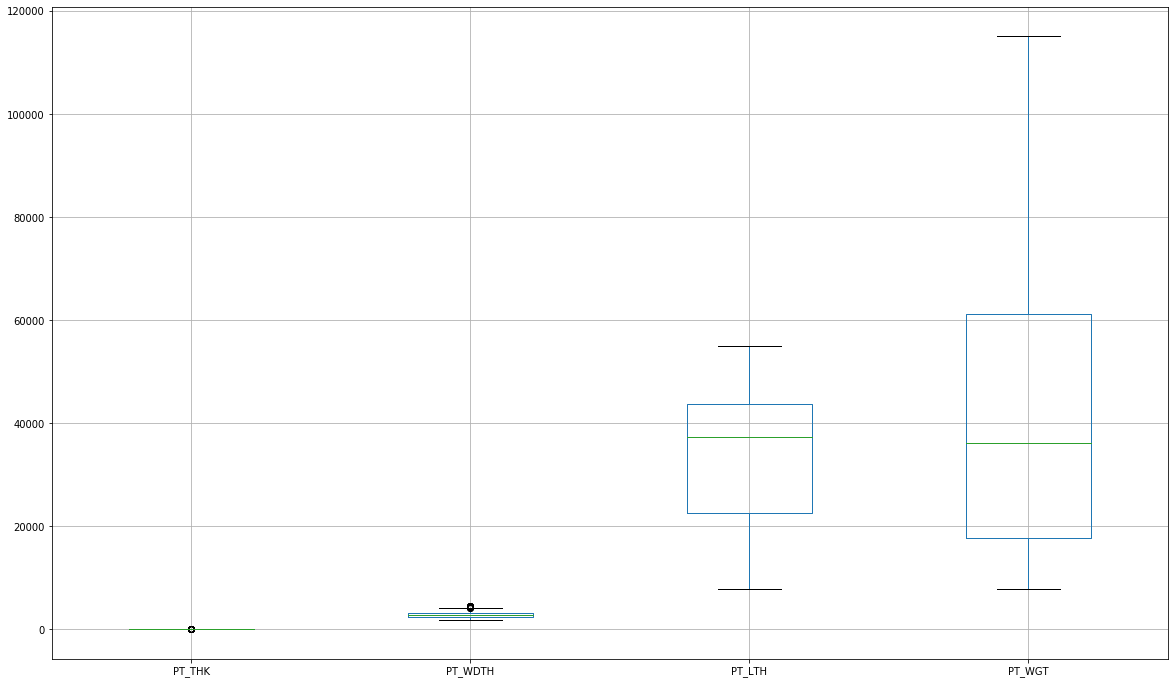

In [8]:
df[['PT_THK','PT_WDTH','PT_LTH','PT_WGT']].boxplot(figsize = (20,12))



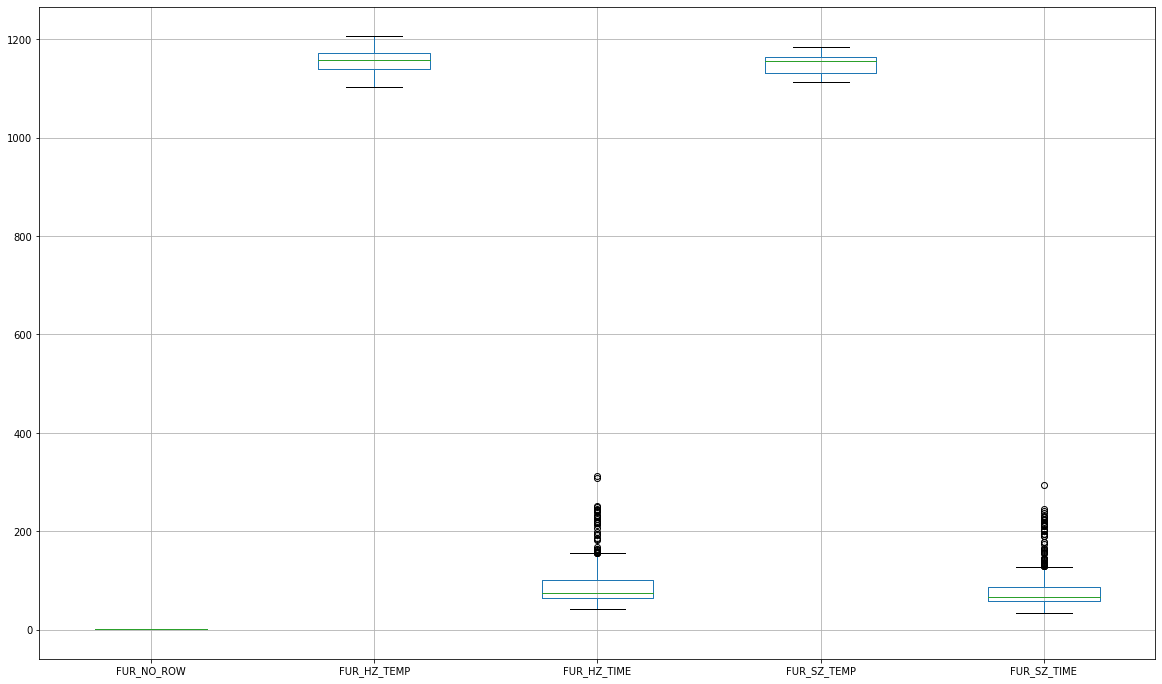

In [9]:
df[['FUR_NO_ROW','FUR_HZ_TEMP','FUR_HZ_TIME','FUR_SZ_TEMP','FUR_SZ_TIME']].boxplot(figsize = (20,12))

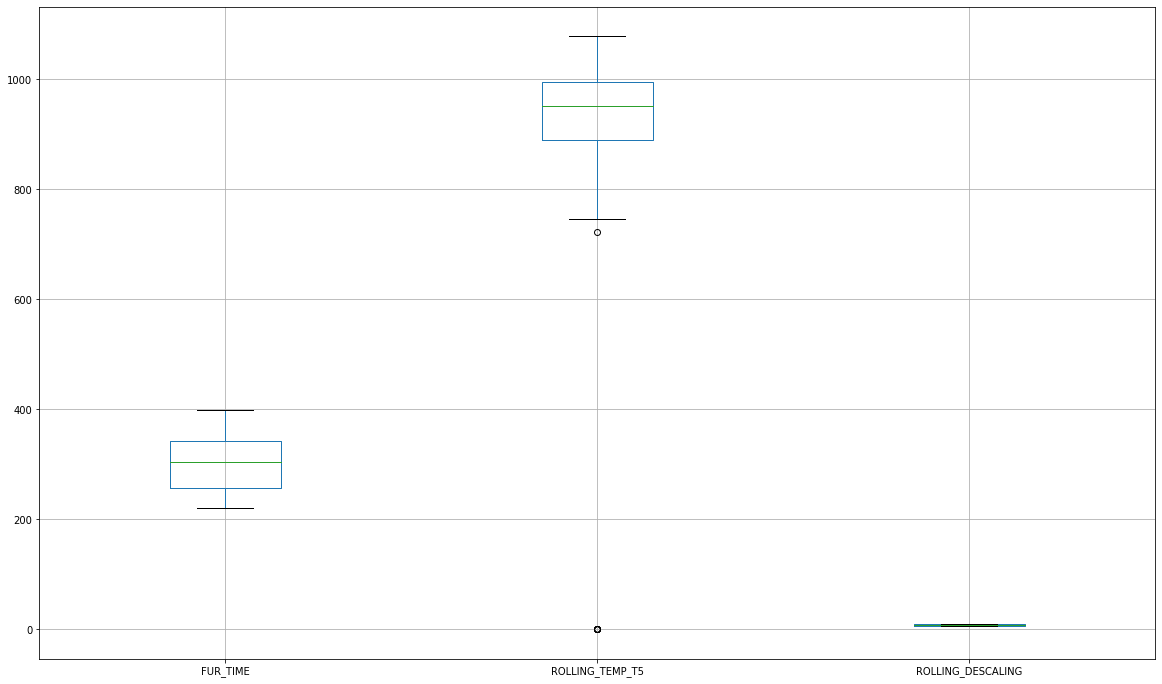

In [10]:
df[['FUR_TIME','ROLLING_TEMP_T5','ROLLING_DESCALING']].boxplot(figsize = (20,12))

In [27]:
len(df)

720

# 치우친것들 로그 변환

In [11]:
# df1 = df
# import math
# from sklearn import preprocessing

# 우측으로 치우친것들 로그변환하기
df['FUR_HZ_TIME'] =np.log(df['FUR_HZ_TIME']) 
df['FUR_SZ_TIME'] =np.log(df['FUR_SZ_TIME']) 
df['PT_WGT'] =np.log(df['PT_WGT']) 
df['PT_THK'] =np.log(df['PT_THK']) 



# 로그변환 한거 분포 확인

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2abafd650>,
      dtype=object)

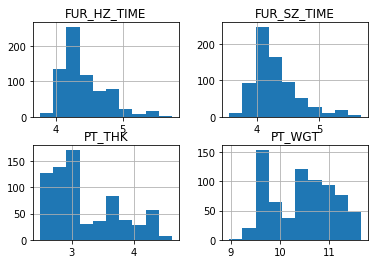

In [12]:
# df_count = df1["FUR_HZ_TIME_log"].value_counts()
# df_count.plot.bar()

# df["FUR_SZ_TIME"].hist()
# df['FUR_HZ_TIME_log'].hist()
# df['FUR_SZ_TIME_log'].hist()
df[['FUR_HZ_TIME','PT_WGT','FUR_SZ_TIME','PT_THK']].hist()

# 더미변수 생성

In [137]:
# df_char = df.select_dtypes(include = 'object')
# df_numeric = df.select_dtypes(exclude = 'object')

# df_char.head()
# df_numeric.head()
#양품은 0 불량은 1 로 바꾸기

# df.head()

# df_dummy=pd.get_dummies(df)
# df_dummy.columns

Index(['SCALE', 'PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO_ROW',
       'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME',
       'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING', 'STEEL_KIND_C0',
       'STEEL_KIND_C1', 'STEEL_KIND_C3', 'STEEL_KIND_T0', 'STEEL_KIND_T1',
       'STEEL_KIND_T3', 'STEEL_KIND_T5', 'STEEL_KIND_T7', 'STEEL_KIND_T8',
       'SPEC_f_AB', 'SPEC_f_BV', 'SPEC_f_CO', 'SPEC_f_GL', 'SPEC_f_JS',
       'SPEC_f_KR', 'SPEC_f_KS', 'SPEC_f_LR', 'SPEC_f_NK', 'SPEC_f_NV',
       'SPEC_f_PI', 'SPEC_f_other'],
      dtype='object')

# 정규화 시작

In [13]:
#로지스틱 회귀용 정규화
df_char = df.select_dtypes(include = 'object')
df_numeric = df.select_dtypes(exclude = 'object')

# df_char.head()
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled,df_char],axis=1)
df_scaled.head()

df_scaled["SCALE"] = np.where(df_scaled["SCALE"]>0,1,0)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,STEEL_KIND,SPEC_f
0,0,0.481732,1.738951,-1.390441,-1.403360,-0.994460,-0.543782,0.991175,-0.949149,-0.607075,-0.409268,0.000734,0.219169,-0.19693,T1,AB
1,0,0.481732,1.738951,-1.390441,-1.403360,1.005571,-0.543782,1.140040,-0.835252,-0.908800,-0.387221,0.028567,0.219169,-0.19693,T1,AB
2,0,0.537714,1.568896,-1.095771,-1.013561,-0.994460,-1.263141,0.991175,-1.632537,-0.804588,-0.409268,-0.416748,0.219169,-0.19693,T8,NV
3,0,0.537714,1.568896,-1.095771,-1.013561,1.005571,-0.160124,1.211749,-1.290843,-0.207656,0.340311,-0.453858,0.219169,-0.19693,T8,NV
4,0,0.792251,0.562094,-1.518889,-1.612302,-0.994460,-0.735611,1.416980,-1.233894,-1.187582,0.296219,-0.565186,0.219169,-0.19693,T8,BV


In [20]:
df_scaled.isnull().sum()

SCALE                0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
STEEL_KIND           0
SPEC_f               0
dtype: int64

### 그외것들을 위한 정규화

In [10]:
len(df_scaled)

720

In [16]:
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,STEEL_KIND,SPEC_f
0,0,0.490458,1.859297,-1.390441,-1.403360,-0.994460,-0.543782,1.025911,-0.949149,-0.612699,-0.409268,-0.126197,0.219169,-0.19693,T1,AB
1,0,0.490458,1.859297,-1.390441,-1.403360,1.005571,-0.543782,1.178732,-0.835252,-0.920162,-0.387221,-0.079653,0.219169,-0.19693,T1,AB
2,0,0.546960,1.679578,-1.095771,-1.013561,-0.994460,-1.263141,1.025911,-1.632537,-0.813969,-0.409268,-0.824359,0.219169,-0.19693,T8,NV
3,0,0.546960,1.679578,-1.095771,-1.013561,1.005571,-0.160124,1.252346,-1.290843,-0.205684,0.340311,-0.886417,0.219169,-0.19693,T8,NV
4,0,0.803859,0.615560,-1.518889,-1.612302,-0.994460,-0.735611,1.463030,-1.233894,-1.204247,0.296219,-1.072594,0.219169,-0.19693,T8,BV


In [14]:
df_train,df_test = train_test_split(df_scaled,test_size = 0.3 ,random_state = 1234)
df_train.shape
# len(df_train)


(504, 16)

In [39]:
df_test.shape

(216, 16)

# 이상치 제거 및 변환


In [15]:
#0값 평균값으로 대체
df_train.loc[df['ROLLING_TEMP_T5']==0, 'ROLLING_TEMP_T5'] = np.mean(df['ROLLING_TEMP_T5'])

#이상치 상한값및 하한값으로 치환
furhz = df_train['FUR_HZ_TIME'].quantile(q=0.975, interpolation='nearest')
fursz = df_train['FUR_SZ_TIME'].quantile(q=0.975, interpolation='nearest')
ptthk = df_train['PT_THK'].quantile(q=0.975, interpolation='nearest')
ptwdth = df_train['PT_WDTH'].quantile(q=0.975, interpolation='nearest')
rollingtemp = df_train['ROLLING_TEMP_T5'].quantile(q=0.025, interpolation='nearest')

df_train.loc[df_train['FUR_HZ_TIME']>furhz, 'FUR_HZ_TIME'] = furhz
df_train.loc[df_train['FUR_SZ_TIME']>fursz, 'FUR_SZ_TIME'] = fursz
df_train.loc[df_train['PT_THK']>ptthk, 'PT_THK'] = ptthk
df_train.loc[df_train['PT_WDTH']>ptwdth, 'PT_WDTH'] = ptwdth
df_train.loc[df_train['ROLLING_TEMP_T5']<rollingtemp, 'ROLLING_TEMP_T5'] = rollingtemp

/home/pirl/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
len(df_train['SPEC_f'].value_counts())

12

In [25]:
len(df_test['SPEC_f'].value_counts())

12

In [26]:
len(df_train['STEEL_KIND'].value_counts())

7

In [27]:
len(df_test['STEEL_KIND'].value_counts())

7

In [16]:
log_model = Logit.from_formula("""SCALE~PT_THK+PT_WDTH+PT_LTH+PT_WGT+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+ROLLING_TEMP_T5+ROLLING_DESCALING+C(STEEL_KIND)+HSB+C(SPEC_f)""",df_train)
scaled_log_result = log_model.fit()
print(scaled_log_result.summary())

         Current function value: 0.259835
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      473
Method:                           MLE   Df Model:                           30
Date:                Sun, 16 Feb 2020   Pseudo R-squ.:                  0.5842
Time:                        17:38:22   Log-Likelihood:                -130.96
converged:                      False   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 7.688e-60
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.9834   1.46e+07   2.72e-07      1.000   -2.87e+07    2.87e+07
C(STEEL_KIND)[T.T0]       -0.

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [17]:
df_train['SPEC_f'].value_counts()

JS       102
NV        74
LR        68
BV        54
GL        42
other     31
AB        29
PI        29
KR        21
KS        19
CO        19
NK        16
Name: SPEC_f, dtype: int64

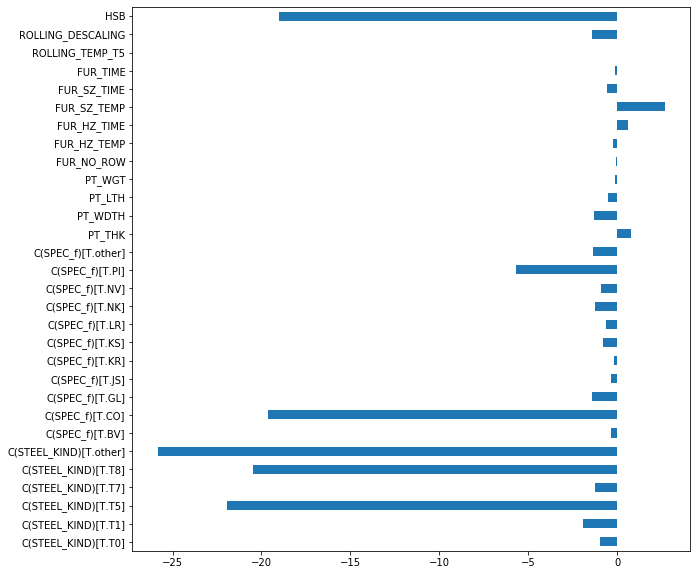

In [18]:
df_log_scaled_coef = pd.DataFrame({"Coef":scaled_log_result.params.values[1:]},
                                 index = log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y='Coef',legend=False,figsize = (10,10))

In [19]:
y_pred = scaled_log_result.predict(df_test)

y_pred_class = (y_pred>0.5).astype(int)
y_pred_class.head()

146    1
131    1
650    0
613    1
355    0
dtype: int64

In [20]:
print(accuracy_score(df_test["SCALE"], y_pred_class))
print(confusion_matrix(df_test["SCALE"],y_pred_class))

0.8379629629629629
[[124  21]
 [ 14  57]]


In [21]:
print(accuracy_score(df_test["SCALE"], y_pred_class))
print(confusion_matrix(df_test["SCALE"],y_pred_class))

0.8379629629629629
[[124  21]
 [ 14  57]]


# 의사결정트리시작

In [22]:
df_dummy_train=pd.get_dummies(df_train)
df_dummy_train.columns

df_train_x = df_dummy_train.drop('SCALE', axis=1)
df_train_y = df_dummy_train['SCALE']

# feature_name = df_x.columns
# print(df_train_x.shape)
# print(df_train_y.shape)
df_train_x.columns

Index(['PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME',
       'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING', 'STEEL_KIND_C0',
       'STEEL_KIND_T0', 'STEEL_KIND_T1', 'STEEL_KIND_T5', 'STEEL_KIND_T7',
       'STEEL_KIND_T8', 'STEEL_KIND_other', 'SPEC_f_AB', 'SPEC_f_BV',
       'SPEC_f_CO', 'SPEC_f_GL', 'SPEC_f_JS', 'SPEC_f_KR', 'SPEC_f_KS',
       'SPEC_f_LR', 'SPEC_f_NK', 'SPEC_f_NV', 'SPEC_f_PI', 'SPEC_f_other'],
      dtype='object')

In [23]:
df_dummy_test=pd.get_dummies(df_test)
df_dummy_test.columns

df_test_x = df_dummy_test.drop('SCALE', axis=1)
df_test_y = df_dummy_test['SCALE']

print(df_test_x.shape)
print(df_test_y.shape)


(216, 32)
(216,)


In [46]:
df_train_x.head()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,...,SPEC_f_CO,SPEC_f_GL,SPEC_f_JS,SPEC_f_KR,SPEC_f_KS,SPEC_f_LR,SPEC_f_NK,SPEC_f_NV,SPEC_f_PI,SPEC_f_other
95,-1.007000,0.921528,1.223746,1.580873,-0.994460,-0.639697,-0.296138,-1.063047,1.436814,1.156030,...,0,0,1,0,0,0,0,0,0,0
427,0.796935,0.621999,-1.312432,-1.284848,-0.994460,-1.119269,-0.810806,-0.892200,1.119819,-0.453361,...,1,0,0,0,0,0,0,0,0,0
206,0.359482,-1.003184,-0.260027,-0.051039,-0.994460,-0.112167,-0.335761,0.303728,0.703287,-0.343129,...,0,0,1,0,0,0,0,0,0,0
59,1.759420,-0.597372,-1.616365,-1.269352,1.005571,-0.879483,0.807445,-1.006098,-0.008040,1.133984,...,1,0,0,0,0,0,0,0,0,0
13,0.365440,-1.675674,0.034282,-1.209828,1.005571,-1.742713,1.327523,-1.689486,-0.334598,0.516683,...,1,0,0,0,0,0,0,0,0,0


In [47]:
df_test_x.head()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,...,SPEC_f_CO,SPEC_f_GL,SPEC_f_JS,SPEC_f_KR,SPEC_f_KS,SPEC_f_LR,SPEC_f_NK,SPEC_f_NV,SPEC_f_PI,SPEC_f_other
146,-0.192882,-0.334559,1.134375,-0.642368,1.005571,0.751064,0.209068,0.987115,-1.072733,-0.078571,...,0,0,0,0,0,0,0,1,0,0
131,-0.556730,-0.554858,0.604373,0.914173,1.005571,0.559235,1.327523,0.930166,-0.422524,0.406451,...,0,0,1,0,0,0,0,0,0,0
650,-1.288188,-0.110396,1.460886,0.339322,1.005571,0.751064,-0.457925,0.702371,-0.249337,-0.894290,...,0,0,0,0,0,0,0,0,0,0
613,-0.361157,-0.827332,0.020098,1.016677,-0.994460,0.751064,-0.180364,0.474575,-0.291644,0.913519,...,0,0,0,0,0,0,0,0,0,1
355,-0.076647,3.416311,-1.230876,-1.346231,1.005571,0.223534,-0.218453,0.588473,-0.378217,-1.048615,...,0,0,0,0,0,1,0,0,0,0


In [24]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

#train 설명력 확인
print(tree_uncustomized.score(df_train_x, df_train_y))
#train 설명력 확인
print(tree_uncustomized.score(df_test_x, df_test_y))


1.0
0.9907407407407407


In [25]:
train_accuracy =[]; test_accuracy = []
para_depth = [depth for depth in range(1,14)]

for v_depth in para_depth:
    tree = DecisionTreeClassifier(random_state=1234, max_depth=v_depth)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy
df_accuracy_depth.round(3)


,Depth,TrainAccuracy,TestAccuracy
0,1,0.875,0.898
1,2,0.929,0.944
2,3,0.958,0.972
3,4,0.966,0.977
4,5,0.968,0.977
5,6,0.972,0.977
6,7,0.972,0.977
7,8,0.978,0.977
8,9,0.978,0.977
9,10,0.990,0.995


No handles with labels found to put in legend.


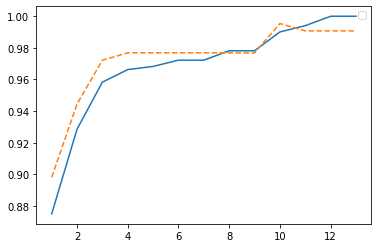

In [26]:
plt.plot(para_depth, train_accuracy, linestyle='-')
plt.plot(para_depth, test_accuracy, linestyle='--')
plt.legend()

In [27]:
train_accuracy =[]; test_accuracy = []
para_split = [i*10 for i in range(1,11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(random_state=1234, max_depth=5,min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['split'] = para_split
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy
df_accuracy_depth.round(3)


,split,TrainAccuracy,TestAccuracy
0,10,0.968,0.977
1,20,0.968,0.977
2,30,0.968,0.977
3,40,0.968,0.977
4,50,0.968,0.977
5,60,0.968,0.977
6,70,0.968,0.977
7,80,0.968,0.977
8,90,0.968,0.977
9,100,0.968,0.977


In [28]:
train_accuracy =[]; test_accuracy = []
para_leaf = [i*2 for i in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(random_state=1234, max_depth=10, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['leaf'] = para_leaf
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy
df_accuracy_depth.round(3)


,leaf,TrainAccuracy,TestAccuracy
0,2,0.986,0.977
1,4,0.978,0.977
2,6,0.980,0.991
3,8,0.976,0.991
4,10,0.972,0.986
5,12,0.966,0.963
6,14,0.956,0.972
7,16,0.952,0.968
8,18,0.942,0.963
9,20,0.942,0.963


In [29]:
tree_final = DecisionTreeClassifier(max_depth=10,min_samples_leaf=6,random_state=1234)
tree_final.fit(df_train_x,df_train_y)
print(tree_final.score(df_train_x,df_train_y))

0.9801587301587301


In [30]:
y_pred = tree_final.predict(df_test_x)
print(tree_final.score(df_test_x, df_test_y))
print(confusion_matrix(df_test_y,y_pred))

0.9907407407407407
[[145   0]
 [  2  69]]


In [31]:
v_feature_name = df_train_x.columns
df_impor = pd.DataFrame()
df_impor['Feature'] = v_feature_name
df_impor['importance'] = tree_final.feature_importances_

df_impor.sort_values("importance", ascending = False, inplace=True)
df_impor.round(3)


,Feature,importance
10,ROLLING_TEMP_T5,0.599
11,HSB,0.159
7,FUR_SZ_TEMP,0.125
12,ROLLING_DESCALING,0.103
25,SPEC_f_KR,0.009
8,FUR_SZ_TIME,0.004
3,PT_WGT,0.001
0,PT_THK,0.000
21,SPEC_f_BV,0.000
22,SPEC_f_CO,0.000


Text(0, 0.5, '설명변수')

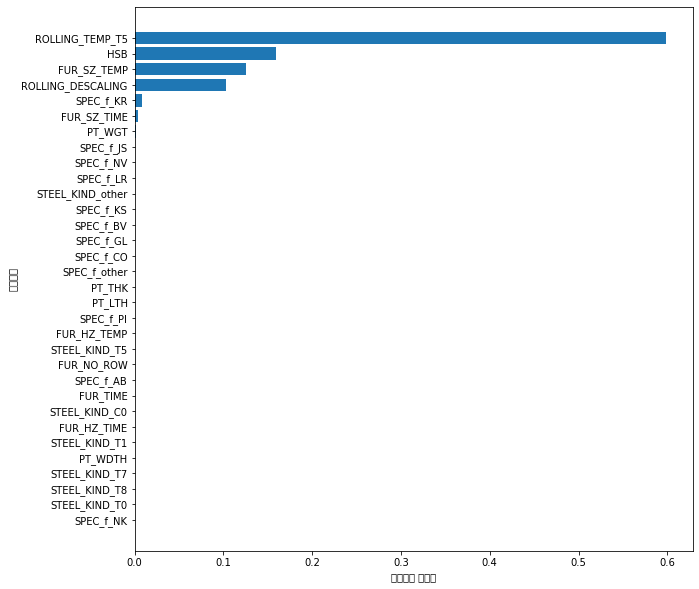

In [42]:

df_impor.sort_values("importance", ascending = True, inplace=True)
plt.figure(figsize=(10, 10))
coordinates = range(len(df_impor))
plt.barh(y=coordinates, width = df_impor['importance'])
plt.yticks(coordinates, df_impor['Feature'])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

In [32]:
tree=RandomForestClassifier(random_state=1234)
tree.fit(df_train_x,df_train_y)

print(tree.score(df_train_x,df_train_y))
print(tree.score(df_test_x,df_test_y))


0.9880952380952381
0.9212962962962963


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
train_score=[]; test_score = []
para_n_tree = [n_tree*10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf=RandomForestClassifier(n_estimators=v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))


df_score_n=pd.DataFrame()
df_score_n['n_estimator']= para_n_tree
df_score_n['TrainScore']= train_score
df_score_n['TestScore']= test_score
df_score_n.round(3)

,n_estimator,TrainScore,TestScore
0,10,0.988,0.921
1,20,0.996,0.958
2,30,0.996,0.949
3,40,1.000,0.954
4,50,1.000,0.958
5,60,1.000,0.954
6,70,1.000,0.958
7,80,1.000,0.954
8,90,1.000,0.944
9,100,1.000,0.949


In [34]:
train_score=[]; test_score = []
para_leaf = [n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestClassifier(n_estimators=20,min_samples_leaf=v_min_samples_leaf, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))


df_score_leaf=pd.DataFrame()
df_score_leaf['leaf']= para_leaf
df_score_leaf['TrainScore']= train_score
df_score_leaf['TestScore']= test_score
df_score_leaf.round(3)

,leaf,TrainScore,TestScore
0,1,0.996,0.958
1,2,0.992,0.949
2,3,0.978,0.944
3,4,0.962,0.912
4,5,0.956,0.917
5,6,0.950,0.926
6,7,0.946,0.921
7,8,0.927,0.903
8,9,0.911,0.898
9,10,0.917,0.884


In [35]:
train_score=[]; test_score = []
para_split = [n_split*2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf=RandomForestClassifier(n_estimators=20,min_samples_leaf=1,min_samples_split=v_min_samples_split, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))


df_score_split=pd.DataFrame()
df_score_split['n_estimator']= para_split
df_score_split['TrainScore']= train_score
df_score_split['TestScore']= test_score
df_score_split.round(3)

,n_estimator,TrainScore,TestScore
0,4,0.996,0.954
1,6,0.992,0.958
2,8,0.984,0.954
3,10,0.986,0.958
4,12,0.982,0.963
5,14,0.980,0.954
6,16,0.968,0.958
7,18,0.978,0.963
8,20,0.970,0.949
9,22,0.966,0.954


In [36]:
train_score=[]; test_score = []
para_depth = [n_depth for n_depth in range(1,20)]

for v_max_depth in para_depth:
    rf=RandomForestClassifier(n_estimators=20,min_samples_leaf=1,min_samples_split=26, max_depth=v_max_depth, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))


df_score_depth=pd.DataFrame()
df_score_depth['depth']= para_depth
df_score_depth['TrainScore']= train_score
df_score_depth['TestScore']= test_score
df_score_depth.round(3)



,depth,TrainScore,TestScore
0,1,0.827,0.829
1,2,0.881,0.889
2,3,0.923,0.907
3,4,0.937,0.921
4,5,0.964,0.958
5,6,0.962,0.958
6,7,0.960,0.954
7,8,0.968,0.940
8,9,0.968,0.949
9,10,0.972,0.944


In [37]:
rf_final = RandomForestClassifier(n_estimators=20,min_samples_leaf=1,min_samples_split=26, max_depth=5, random_state = 1234)
rf_final.fit(df_train_x,df_train_y)

print(rf_final.score(df_train_x, df_train_y))
print(rf_final.score(df_test_x, df_test_y))

0.9642857142857143
0.9583333333333334


In [38]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)


,Feature,Importance
10,ROLLING_TEMP_T5,0.374
11,HSB,0.107
7,FUR_SZ_TEMP,0.094
13,STEEL_KIND_C0,0.084
12,ROLLING_DESCALING,0.061
5,FUR_HZ_TEMP,0.049
1,PT_WDTH,0.045
0,PT_THK,0.041
8,FUR_SZ_TIME,0.026
3,PT_WGT,0.024


In [39]:
estimator = RandomForestClassifier(random_state=1234, n_estimators=20)
param_grid = {
             "max_depth":para_depth, "min_samples_s\plit":para_split,
             "min_samples_leaf":para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs =-1)
grid_dt.fit(df_train_x, df_train_y)

print(grid_dt.best_estimator_)
print(grid_dt.best_params_)
print(grid_dt.best_score_.round(3))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=28,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 28}
0.94


In [69]:
tree = GradientBoostingClassifier(random_state=1234)
tree.fit(df_train_x,df_train_y)
print(tree.score(df_train_x,df_train_y))
print(tree.score(df_test_x,df_test_y))

1.0
1.0


In [43]:
train_score=[]; test_score = []
para_lr = [i*0.1 for i in range(1,10)]

for v_learning_rate in para_lr:
    rf=GradientBoostingClassifier(learning_rate=v_learning_rate, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
df_score_n=pd.DataFrame()
df_score_n['learning_rate']= para_lr
df_score_n['TrainScore']= train_score
df_score_n['TestScore']= test_score
df_score_n.round(3)

,learning_rate,TrainScore,TestScore
0,0.1,1.0,1.000
1,0.2,1.0,1.000
2,0.3,1.0,1.000
3,0.4,1.0,1.000
4,0.5,1.0,1.000
5,0.6,1.0,0.986
6,0.7,1.0,0.991
7,0.8,1.0,0.986
8,0.9,1.0,0.995


In [44]:
train_score=[]; test_score = []
para_n_tree = [n_tree*10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf=GradientBoostingClassifier(n_estimators=v_n_estimators,learning_rate=0.1, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))


df_score_n=pd.DataFrame()
df_score_n['n_estimator']= para_n_tree
df_score_n['TrainScore']= train_score
df_score_n['TestScore']= test_score
df_score_n.round(3)

,n_estimator,TrainScore,TestScore
0,10,0.958,0.972
1,20,0.966,0.977
2,30,0.966,0.977
3,40,0.990,0.986
4,50,0.994,0.991
5,60,0.998,0.991
6,70,1.000,0.995
7,80,1.000,0.995
8,90,1.000,1.000
9,100,1.000,1.000


In [45]:
train_score=[]; test_score = []
para_depth = [n_depth for n_depth in range(1,20)]

for v_max_depth in para_depth:
    rf=GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=v_max_depth, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))


df_score_depth=pd.DataFrame()
df_score_depth['depth']= para_depth
df_score_depth['TrainScore']= train_score
df_score_depth['TestScore']= test_score
df_score_depth.round(3)



,depth,TrainScore,TestScore
0,1,0.966,0.977
1,2,0.994,0.995
2,3,1.000,1.000
3,4,1.000,0.995
4,5,1.000,0.995
5,6,1.000,0.991
6,7,1.000,0.977
7,8,1.000,0.991
8,9,1.000,0.991
9,10,1.000,0.991


In [46]:
train_score=[]; test_score = []
para_split = [n_split*2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf=GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,min_samples_split=v_min_samples_split, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))


df_score_split=pd.DataFrame()
df_score_split['n_estimator']= para_split
df_score_split['TrainScore']= train_score
df_score_split['TestScore']= test_score
df_score_split.round(3)

,n_estimator,TrainScore,TestScore
0,4,1.0,1.000
1,6,1.0,1.000
2,8,1.0,0.995
3,10,1.0,0.995
4,12,1.0,0.995
5,14,1.0,1.000
6,16,1.0,1.000
7,18,1.0,0.995
8,20,1.0,1.000
9,22,1.0,1.000


In [47]:
train_score=[]; test_score = []
para_leaf = [n_leaf*10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf=GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=4,min_samples_leaf=v_min_samples_leaf, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))


df_score_leaf=pd.DataFrame()
df_score_leaf['leaf']= para_leaf
df_score_leaf['TrainScore']= train_score
df_score_leaf['TestScore']= test_score
df_score_leaf.round(3)

,leaf,TrainScore,TestScore
0,10,1.000,0.995
1,20,0.998,0.995
2,30,0.976,0.931
3,40,0.974,0.921
4,50,0.964,0.926
5,60,0.952,0.940
6,70,0.950,0.931
7,80,0.942,0.907
8,90,0.927,0.931
9,100,0.929,0.926


In [50]:
gb_final = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,min_samples_leaf=10,min_samples_split=14, random_state = 1234)
gb_final.fit(df_train_x,df_train_y)
y_pred = gb_final.predict(df_test_x) 


print(gb_final.score(df_train_x, df_train_y))
print(gb_final.score(df_test_x, df_test_y))
print(confusion_matrix(df_test_y,y_pred))

0.9940476190476191
0.9953703703703703
[[145   0]
 [  1  70]]


In [51]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)


,Feature,Importance
10,ROLLING_TEMP_T5,0.583
11,HSB,0.161
7,FUR_SZ_TEMP,0.139
12,ROLLING_DESCALING,0.052
0,PT_THK,0.039
9,FUR_TIME,0.006
8,FUR_SZ_TIME,0.005
1,PT_WDTH,0.003
6,FUR_HZ_TIME,0.003
17,STEEL_KIND_T7,0.002


In [197]:
df_dummy=pd.get_dummies(df['STEEL_KIND'])
df_dummy

,C0,C1,C3,T0,T1,T3,T5,T7,T8
0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
715,1,0,0,0,0,0,0,0,0
716,1,0,0,0,0,0,0,0,0
717,1,0,0,0,0,0,0,0,0
718,1,0,0,0,0,0,0,0,0


In [34]:
df['SCALE'].value_counts()

0    489
1    231
Name: SCALE, dtype: int64

In [396]:
df['PT_THK']

0      3.473518
1      3.473518
2      3.504656
3      3.504656
4      3.646233
         ...   
715    3.002708
716    2.713369
717    2.809403
718    2.746630
719    2.778198
Name: PT_THK, Length: 720, dtype: float64

In [35]:
df['SPEC'].value_counts()

JS-SM490YB     84
LR-A           54
NV-A           48
PILAC-BT33     40
BV-EH36-TM     35
               ..
BV-EH32-TM      1
A131-DH36TM     1
BV-A            1
A709-36         1
KR-B            1
Name: SPEC, Length: 66, dtype: int64

In [36]:
df['STEEL_KIND'].value_counts()

C0    503
T8     95
T5     43
T7     35
T1     18
T0     16
C3      7
T3      2
C1      1
Name: STEEL_KIND, dtype: int64

In [ ]:
df['STEEL_KIND'].value_counts()

4조    194
1조    189
3조    172
2조    165
Name: WORK_GR, dtype: int64

In [39]:
grouped = df['SCALE'].groupby(df['WORK_GR'])
grouped.size()

WORK_GR
1조    189
2조    165
3조    172
4조    194
Name: SCALE, dtype: int64

In [40]:
grouped = df['SCALE'].groupby(df['HSB'])
grouped.size()

HSB
미적용     33
적용     687
Name: SCALE, dtype: int64

In [44]:
df.groupby(['HSB','SCALE'])['SCALE'].size()

HSB  SCALE
미적용  1         33
적용   0        489
     1        198
Name: SCALE, dtype: int64

## HSB적용을 안하면 다 불량임

In [45]:
df.groupby(['HSB','SCALE']).size()

HSB  SCALE
미적용  1         33
적용   0        489
     1        198
dtype: int64

## 가열로 호기에 따른 불량품 발생건수는 3호기에서 더 많지만 비슷함
## 카이스퀘어 검정 결과 가열로 호기는 전혀 상관없음

In [122]:
out = pd.DataFrame(df.groupby(['FUR_NO','SCALE']).size())
# out.pivotout

out = out.reset_index(level = ['FUR_NO', 'SCALE'])
out = out.pivot(index='FUR_NO',columns='SCALE',values = 0)
print(out)

from scipy.stats import chisquare
chi, pval , dof , expected = stats.chi2_contingency(out) # 전치 행렬로 열을 집어 넣는게 포인트임 !
print(pval)


SCALE     0   1
FUR_NO         
1호기     167  73
2호기     167  70
3호기     155  88
0.2328665147101705


/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0, flags=flags)


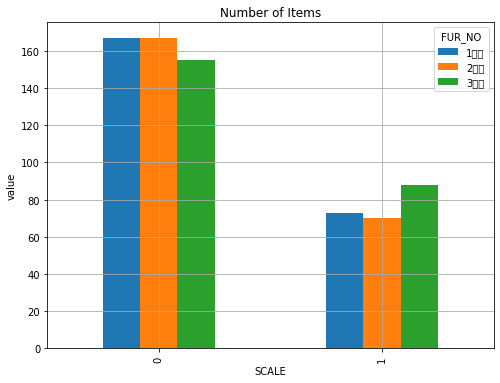

In [77]:
ax = out.plot(kind='bar', title='Number of Items', figsize=(8, 6))
ax.set_ylabel('value')
plt.grid(color='darkgray')
plt.show()

## 작업조에 따른 불량품 발생건수
## 카이스퀘어 검정 결과 작업조는 전혀 상관없음

In [89]:
out = pd.DataFrame(df.groupby(['WORK_GR','SCALE']).size())
# out.pivotoudf['SPEC_f'] = t

out = out.reset_index(level = ['WORK_GR', 'SCALE'])
out = out.pivot(index='WORK_GR',columns='SCALE',values = 0)
print(out)

from scipy.stats import chisquare
chi, pval , dof , expected = stats.chi2_contingency(out) # 전치 행렬로 열을 집어 넣는게 포인트임 !
print(pval)

SCALE      0   1
WORK_GR         
1조       122  67
2조       120  45
3조       118  54
4조       129  65
0.39897724814139857


## SPEC_F별로 불량품 발생건수
## 카이스퀘어 검정 결과 상관있음

In [182]:
tmp=[]
for i in df['SPEC']:
    tmp.append(i[0:2])

df['SPEC_f'] = tmp

df= df.drop(['PLATE_NO','ROLLING_DATE','WORK_GR','FUR_NO'],axis=1)


In [121]:
out = pd.DataFrame(df.groupby(['SPEC_f','SCALE']).size())
# out.pivotout

out = out.reset_index(level = ['SPEC_f', 'SCALE'])
out = out.pivot(index='SPEC_f',columns='SCALE',values = 0)
out.fillna(0,inplace=True)
print(out)

from scipy.stats import chisquare
chi, pval , dof , expected = stats.chi2_contingency(out) # 전치 행렬로 열을 집어 넣는게 포인트임 !
print(pval)

SCALE      0     1
SPEC_f            
A1       0.0   1.0
A2       1.0   5.0
A5       1.0   1.0
A7       1.0   0.0
AB      28.0   9.0
AP       2.0   0.0
BV      72.0  14.0
CC       0.0   1.0
CO      26.0   2.0
GL      49.0   7.0
JS      60.0  86.0
KR      13.0  18.0
KS      12.0  16.0
LR      77.0  28.0
NK      17.0   3.0
NV      78.0  27.0
PI      38.0   2.0
SA      11.0  10.0
V4       3.0   1.0
6.025640271309803e-19


## 강종별 불량품 확인
### 강종별 불량품 이상있음

In [138]:
out = pd.DataFrame(df.groupby(['STEEL_KIND','SCALE']).size())
# out.pivotoudf['SPEC_f'] = t

out = out.reset_index(level = ['STEEL_KIND', 'SCALE'])
out = out.pivot(index='STEEL_KIND',columns='SCALE',values = 0)

out.fillna(0,inplace=True)
print(out)
from scipy.stats import chisquare
chi, pval , dof , expected = stats.chi2_contingency(out) # 전치 행렬로 열을 집어 넣는게 포인트임 !
print(pval)

SCALE           0      1
STEEL_KIND              
C0          291.0  212.0
C1            0.0    1.0
C3            6.0    1.0
T0           14.0    2.0
T1           16.0    2.0
T3            2.0    0.0
T5           41.0    2.0
T7           29.0    6.0
T8           90.0    5.0
8.754375220184464e-15


In [160]:
a = df.query('SCALE == 1 ')
a = a[a['WORK_GR']=='4조']

# a=pd.DataFrame(a['WORK_GR',"SPEC_f"])
# a.values_counts()
a = a["SPEC_f"]
# df.query('A>0.5 & B<0.0')
a.value_counts()


JS    22
NV    10
LR     7
KR     6
AB     4
KS     4
BV     3
SA     3
A2     2
CC     1
NK     1
GL     1
CO     1
Name: SPEC_f, dtype: int64

In [161]:
df.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,SPEC_f
0,PB562774,2008-08-01:00:00:15,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,116,1133,59,282,1133,934,적용,8,2조,AB
1,PB562775,2008-08-01:00:00:16,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,122,1135,53,283,1135,937,적용,8,2조,AB
2,PB562776,2008-08-01:00:00:59,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,116,1121,55,282,1121,889,적용,8,3조,NV
3,PB562777,2008-08-01:00:01:24,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,125,1127,68,316,1127,885,적용,8,3조,NV
4,PB562778,2008-08-01:00:01:44,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,134,1128,48,314,1128,873,적용,8,1조,BV


In [ ]:
df[['MEDV','CRIM','ZN','INDUS','CHAS']].boxplot(figsize = (20,12))

In [279]:
df.corr().round(3)

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
SCALE,1.000,-0.125,-0.206,0.100,0.219,-0.023,0.248,0.048,0.375,-0.251,-0.049,0.375,0.552,-0.007
PT_THK,-0.125,1.000,-0.313,-0.863,-0.397,-0.003,-0.524,0.192,-0.695,0.158,0.413,-0.695,-0.497,-0.837
PT_WDTH,-0.206,-0.313,1.000,0.120,0.031,0.007,0.180,-0.131,0.227,0.000,-0.393,0.227,-0.111,0.338
PT_LTH,0.100,-0.863,0.120,1.000,0.452,-0.021,0.473,-0.108,0.645,-0.114,-0.252,0.645,0.432,0.809
PT_WGT,0.219,-0.397,0.031,0.452,1.000,-0.022,0.153,-0.012,0.360,-0.199,-0.058,0.360,0.419,0.239
FUR_NO_ROW,-0.023,-0.003,0.007,-0.021,-0.022,1.000,0.005,-0.007,0.009,0.050,0.016,0.009,-0.007,0.018
FUR_HZ_TEMP,0.248,-0.524,0.180,0.473,0.153,0.005,1.000,-0.119,0.773,-0.256,-0.348,0.773,0.355,0.471
FUR_HZ_TIME,0.048,0.192,-0.131,-0.108,-0.012,-0.007,-0.119,1.000,-0.236,0.203,0.503,-0.236,-0.021,-0.165
FUR_SZ_TEMP,0.375,-0.695,0.227,0.645,0.360,0.009,0.773,-0.236,1.000,-0.492,-0.477,1.000,0.658,0.649
FUR_SZ_TIME,-0.251,0.158,0.000,-0.114,-0.199,0.050,-0.256,0.203,-0.492,1.000,0.469,-0.492,-0.414,-0.156


In [179]:
df

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,SPEC_f
0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조,AB
1,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조,AB
2,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조,NV
3,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조,NV
4,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조,BV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,NK-KA,C0,20.14,3580,38639,21870,3호기,1,1172,72,1164,62,245,1164,1005,적용,8,2조,NK
716,0,NV-A32,C0,15.08,3212,48233,18340,2호기,1,1150,61,1169,61,238,1169,947,적용,10,1조,NV
717,0,NV-A32,C0,16.60,3441,43688,19590,2호기,2,1169,65,1163,77,247,1163,948,적용,10,4조,NV
718,0,LR-A,C0,15.59,3363,48740,80240,3호기,2,1179,86,1163,45,243,1163,940,적용,10,2조,LR


In [175]:
df[['MEDV','CRIM','ZN','INDUS','CHAS']].boxplot(figsize = (20,12))

,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME
177,2040,38774,35580,2호기,2,1172,72,1166,54
180,2040,38774,35580,1호기,1,1164,76,1162,69
637,2040,38774,35580,2호기,1,1146,81,1151,61
663,2040,38774,35580,3호기,1,1145,61,1152,68
664,2040,38774,35580,3호기,2,1168,71,1162,56
